In [26]:
import numpy as np
import pandas as pd
import cv2

In [27]:
df = pd.read_csv('challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv')

In [28]:
df.head(10)

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
5,2,Training,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...
6,4,Training,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
7,3,Training,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...
8,3,Training,85 84 90 121 101 102 133 153 153 169 177 189 1...
9,2,Training,255 254 255 254 254 179 122 107 95 124 149 150...


In [29]:
df[' pixels']

0        70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        151 150 147 155 148 133 111 140 170 174 182 15...
2        231 212 156 164 174 138 161 173 182 200 106 38...
3        24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
                               ...                        
35882    50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883    178 174 172 173 181 188 191 194 196 199 200 20...
35884    17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885    30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...
35886    19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...
Name:  pixels, Length: 35887, dtype: object

In [30]:
def to_img(row):
    return np.array(row[' pixels'].split(' ')).reshape(48,48).astype('uint8')

In [31]:
df['img'] = df.apply(to_img, axis=1)

In [32]:
df['img'][0]

array([[ 70,  80,  82, ...,  52,  43,  41],
       [ 65,  61,  58, ...,  56,  52,  44],
       [ 50,  43,  54, ...,  49,  56,  47],
       ...,
       [ 91,  65,  42, ...,  72,  56,  43],
       [ 77,  82,  79, ..., 105,  70,  46],
       [ 77,  72,  84, ..., 106, 109,  82]], dtype=uint8)

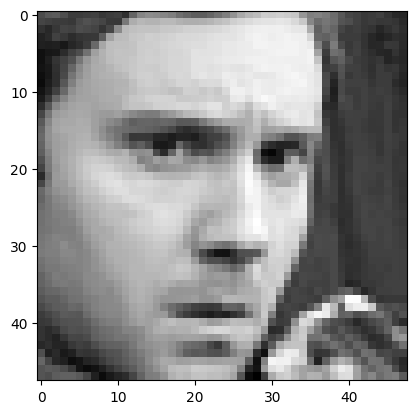

In [33]:
import matplotlib.pyplot as plt
plt.imshow(df['img'][0], cmap='gray')
plt.show()

In [34]:
from tqdm import tqdm
import mediapipe as mp

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh

In [35]:
def prepareforANN(lanmarks):
    return np.array([[landmark.x, landmark.y, landmark.z] for landmark in lanmarks])

In [36]:
def drawalllandmark(annotated_image, result):
    for face_landmarks in result.multi_face_landmarks:
        # print('face_landmarks:', face_landmarks)
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles.
            get_default_face_mesh_tesselation_style())
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles.
            get_default_face_mesh_contours_style())
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_IRISES,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles.
            get_default_face_mesh_iris_connections_style())
        
    return annotated_image

In [37]:
def emotionmapping(emotion):
    if emotion == 0:
        return 'anger'
    elif emotion == 1:
        return 'disgust'
    elif emotion == 2:
        return 'fear'
    elif emotion == 3:
        return 'happy'
    elif emotion == 4:
        return 'sad'
    elif emotion == 5:
        return 'surprise'
    elif emotion == 6:
        return 'neutral'

In [42]:
def getlandmark(df):
    new_df = pd.DataFrame(columns=['usage', 'feature', 'target'])
    with mp_face_mesh.FaceMesh(static_image_mode=True,
                               max_num_faces=1,
                               refine_landmarks=True,
                               min_detection_confidence=0.5) as face_mesh:
        for data in tqdm(df[[' Usage','img', 'emotion']].values):
            # Convert the BGR image to RGB before processing.
            result = face_mesh.process(cv2.cvtColor(data[1], cv2.COLOR_GRAY2RGB))
            emotion = data[2]
            # Print and draw face mesh landmarks on the image.
            if not result.multi_face_landmarks:
                continue
            np_landmark = prepareforANN(result.multi_face_landmarks[0].landmark)
            new_df = pd.concat([new_df, pd.DataFrame([[data[0], np_landmark, emotion]], columns=['usage', 'feature', 'target'])], ignore_index=True)
            annotated_image = cv2.cvtColor(data[1], cv2.COLOR_GRAY2RGB).copy()
            annotated_image = drawalllandmark(annotated_image, result)
            plt.imshow(annotated_image)
    return new_df


100%|██████████| 100/100 [00:02<00:00, 44.55it/s]


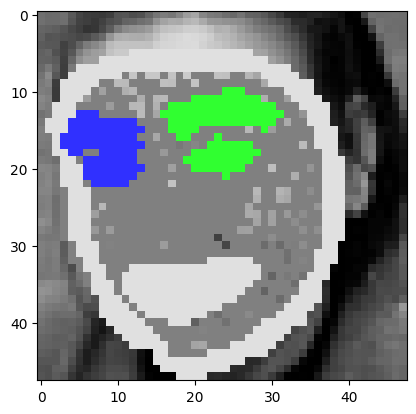

In [50]:
result = getlandmark(df[:100])

In [51]:
result

,usage,feature,target
0,Training,"[[0.5199680328369141, 0.7789784669876099, -0.0...",0
1,Training,"[[0.5085993409156799, 0.7591274380683899, -0.1...",0
2,Training,"[[0.33950066566467285, 0.7026019096374512, -0....",2
3,Training,"[[0.5091360807418823, 0.7863333821296692, -0.0...",6
4,Training,"[[0.5136174559593201, 0.7689816951751709, -0.1...",2
...,...,...,...
90,Training,"[[0.4796594977378845, 0.8034297227859497, -0.0...",2
91,Training,"[[0.5051054358482361, 0.7784324884414673, -0.1...",2
92,Training,"[[0.4124206304550171, 0.7028744220733643, -0.0...",3
93,Training,"[[0.4399617910385132, 0.7254733443260193, -0.0...",4


In [52]:
result['target']

0     0
1     0
2     2
3     6
4     2
     ..
90    2
91    2
92    3
93    4
94    3
Name: target, Length: 95, dtype: object

In [53]:
train_df = result[result['usage'] == 'Training'].drop(columns='usage')
test_df = result[result['usage'] == 'PrivateTest'].drop(columns='usage')

In [64]:
x = train_df.iloc[0].to_numpy()

In [69]:
x[:-1]

array([array([[ 0.51996803,  0.77897847, -0.06618965],
              [ 0.60105777,  0.65294325, -0.14991091],
              [ 0.55322665,  0.67716253, -0.07121652],
              ...,
              [ 0.63412535,  0.35760406,  0.10183166],
              [ 0.60267019,  0.38566893,  0.10183166],
              [ 0.63281775,  0.41986841,  0.10183166]])], dtype=object)

In [60]:
import facemeshANN

In [61]:
model = facemeshANN.ANNClassifier(478*3, 8)
model = facemeshANN.trainmodel(model, train_df, test_df)

TypeError: 'int' object is not callable